In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold,KFold
import warnings
import os
from six.moves import urllib
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn')
from scipy.stats import norm, skew
import plotly
from plotly.plotly import iplot
import plotly.graph_objs as go

In [2]:
os.listdir('../input/')

['test.csv',
 'mulliken_charges.csv',
 'dipole_moments.csv',
 'train.csv',
 'structures.csv',
 'magnetic_shielding_tensors.csv',
 'potential_energy.csv',
 'sample_submission.csv',
 'scalar_coupling_contributions.csv',
 'structures']

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

<pre> <b> Define Train and Test Set</b></pre>

In [4]:
train = reduce_mem_usage(pd.read_csv('../input/train.csv'))
test = reduce_mem_usage(pd.read_csv('../input/test.csv'))
mulliken = reduce_mem_usage(pd.read_csv('../input/mulliken_charges.csv'))
dipole = reduce_mem_usage(pd.read_csv('../input/dipole_moments.csv'))
structure = reduce_mem_usage(pd.read_csv('../input/structures.csv'))
potential = reduce_mem_usage(pd.read_csv('../input/potential_energy.csv'))
magnetic = reduce_mem_usage(pd.read_csv('../input/magnetic_shielding_tensors.csv'))
scaler = reduce_mem_usage(pd.read_csv('../input/scalar_coupling_contributions.csv'))
sub = reduce_mem_usage(pd.read_csv('../input/sample_submission.csv'))

Mem. usage decreased to 106.62 Mb (50.0% reduction)
Mem. usage decreased to 52.57 Mb (45.0% reduction)
Mem. usage decreased to 16.09 Mb (54.2% reduction)
Mem. usage decreased to  1.13 Mb (56.2% reduction)
Mem. usage decreased to 51.74 Mb (52.1% reduction)
Mem. usage decreased to  0.81 Mb (37.5% reduction)
Mem. usage decreased to 39.49 Mb (69.3% reduction)
Mem. usage decreased to 115.50 Mb (59.4% reduction)
Mem. usage decreased to 11.95 Mb (68.7% reduction)


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4658147 entries, 0 to 4658146
Data columns (total 6 columns):
id                          int32
molecule_name               object
atom_index_0                int8
atom_index_1                int8
type                        object
scalar_coupling_constant    float16
dtypes: float16(1), int32(1), int8(2), object(2)
memory usage: 106.6+ MB


In [6]:
train.describe()

,id,atom_index_0,atom_index_1,scalar_coupling_constant
count,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06
mean,2.329073e+06,1.335689e+01,5.883966e+00,NaN
std,1.344691e+06,3.267712e+00,4.993943e+00,0.000000e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-3.621875e+01
25%,1.164536e+06,1.100000e+01,2.000000e+00,-2.548828e-01
50%,2.329073e+06,1.300000e+01,5.000000e+00,2.281250e+00
75%,3.493610e+06,1.600000e+01,8.000000e+00,7.390625e+00
max,4.658146e+06,2.800000e+01,2.800000e+01,2.048750e+02


In [7]:
train.head(10)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.812500
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.257812
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.257812
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.257812
4,4,dsgdb9nsd_000001,2,0,1JHC,84.812500
5,5,dsgdb9nsd_000001,2,3,2JHH,-11.257812
6,6,dsgdb9nsd_000001,2,4,2JHH,-11.257812
7,7,dsgdb9nsd_000001,3,0,1JHC,84.812500
8,8,dsgdb9nsd_000001,3,4,2JHH,-11.257812
9,9,dsgdb9nsd_000001,4,0,1JHC,84.812500


In [8]:
print(mulliken.shape)
print(mulliken.head(10))

(1533537, 3)
      molecule_name  atom_index  mulliken_charge
0  dsgdb9nsd_000001           0        -0.535645
1  dsgdb9nsd_000001           1         0.133911
2  dsgdb9nsd_000001           2         0.133911
3  dsgdb9nsd_000001           3         0.133911
4  dsgdb9nsd_000001           4         0.133911
5  dsgdb9nsd_000002           0        -0.707031
6  dsgdb9nsd_000002           1         0.235718
7  dsgdb9nsd_000002           2         0.235718
8  dsgdb9nsd_000002           3         0.235718
9  dsgdb9nsd_000003           0        -0.589844


In [9]:
print(dipole.shape)
print(dipole.head(10))

(85003, 4)
      molecule_name         X         Y         Z
0  dsgdb9nsd_000001  0.000000  0.000000  0.000000
1  dsgdb9nsd_000002 -0.000200  0.000000  1.625977
2  dsgdb9nsd_000003  0.000000  0.000000 -1.851562
3  dsgdb9nsd_000005  0.000000  0.000000 -2.894531
4  dsgdb9nsd_000007  0.000000  0.000000  0.000000
5  dsgdb9nsd_000008  0.650391 -1.379883 -0.000200
6  dsgdb9nsd_000009  0.715820  0.000400 -0.000400
7  dsgdb9nsd_000010  3.826172  0.000000 -0.000100
8  dsgdb9nsd_000011  2.361328  1.011719  0.000400
9  dsgdb9nsd_000012 -3.662109  0.705566  0.000900


In [10]:
print(structure.shape)
print(structure.head(10))

(2358657, 6)
      molecule_name  atom_index atom         x         y         z
0  dsgdb9nsd_000001           0    C -0.012695  1.085938  0.008003
1  dsgdb9nsd_000001           1    H  0.002150 -0.006031  0.001976
2  dsgdb9nsd_000001           2    H  1.011719  1.463867  0.000277
3  dsgdb9nsd_000001           3    H -0.541016  1.447266 -0.876465
4  dsgdb9nsd_000001           4    H -0.523926  1.437500  0.906250
5  dsgdb9nsd_000002           0    N -0.040436  1.024414  0.062561
6  dsgdb9nsd_000002           1    H  0.017258  0.012543 -0.027374
7  dsgdb9nsd_000002           2    H  0.916016  1.358398 -0.028763
8  dsgdb9nsd_000002           3    H -0.520508  1.343750 -0.775391
9  dsgdb9nsd_000003           0    O -0.034363  0.977539  0.007603


In [11]:
print(magnetic.shape)
print(magnetic.head(5))

(1533537, 11)
      molecule_name  atom_index     ...            YZ          ZZ
0  dsgdb9nsd_000001           0     ...      0.000700  195.375000
1  dsgdb9nsd_000001           1     ...     -1.717773   34.093750
2  dsgdb9nsd_000001           2     ...     -1.603516   33.906250
3  dsgdb9nsd_000001           3     ...      1.695312   28.953125
4  dsgdb9nsd_000001           4     ...      1.625977   28.906250

[5 rows x 11 columns]


In [12]:
print(potential.shape)
print(potential.head(10))

(85003, 2)
      molecule_name  potential_energy
0  dsgdb9nsd_000001         -40.53125
1  dsgdb9nsd_000002         -56.56250
2  dsgdb9nsd_000003         -76.43750
3  dsgdb9nsd_000005         -93.43750
4  dsgdb9nsd_000007         -79.81250
5  dsgdb9nsd_000008        -115.75000
6  dsgdb9nsd_000009        -116.68750
7  dsgdb9nsd_000010        -132.75000
8  dsgdb9nsd_000011        -153.87500
9  dsgdb9nsd_000012        -169.87500


In [13]:
print(scaler.shape)
print(scaler.head(10))

(4658147, 8)
      molecule_name  atom_index_0    ...          pso       dso
0  dsgdb9nsd_000001             1    ...     1.258789  0.271973
1  dsgdb9nsd_000001             1    ...     2.857422 -3.433594
2  dsgdb9nsd_000001             1    ...     2.859375 -3.433594
3  dsgdb9nsd_000001             1    ...     2.859375 -3.433594
4  dsgdb9nsd_000001             2    ...     1.258789  0.271973
5  dsgdb9nsd_000001             2    ...     2.859375 -3.433594
6  dsgdb9nsd_000001             2    ...     2.859375 -3.433594
7  dsgdb9nsd_000001             3    ...     1.258789  0.271973
8  dsgdb9nsd_000001             3    ...     2.859375 -3.433594
9  dsgdb9nsd_000001             4    ...     1.258789  0.271973

[10 rows x 8 columns]


In [14]:
#Check for Missing Values

obs = train.isnull().sum().sort_values(ascending = False)
percent = round(train.isnull().sum().sort_values(ascending = False)/len(train)*100, 2)
pd.concat([obs, percent], axis = 1,keys= ['Number of Observations', 'Percent'])

,Number of Observations,Percent
scalar_coupling_constant,0,0.0
type,0,0.0
atom_index_1,0,0.0
atom_index_0,0,0.0
molecule_name,0,0.0
id,0,0.0


<pre>Prepare One Hot Encoder for Object Datatypes</pre>

In [15]:
def one_hot_encoder(data):
    original_columns = data.columns.tolist()
    categorical_columns = list(filter(lambda c: c in ['object'], data.dtypes))
    new_data = pd.get_dummies(data, columns=categorical_columns)

    new_columns = list(filter(lambda c: c not in original_columns, new_data.columns))
    return new_data, new_columns

<pre> Exploratory Analytics </pre>

In [16]:
#Distribution for Target Variable
plotly.tools.set_credentials_file('roy.gupta','LIKu6GnqVhkB1BaoUuHP') # Please change the credentials in your version

trace1 = go.Histogram(
    x= train['scalar_coupling_constant'],
    opacity=0.75,
    name = "scalar_coupling_constant",
    marker=dict(color='rgba(171, 50, 96, 0.6)'))

data = [trace1]
layout = go.Layout(barmode='overlay',
                   title='Distribution of scalar coupling constant'
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [17]:
import gc
gc.collect()

46

In [18]:
plotly.tools.set_credentials_file('roy.gupta','LIKu6GnqVhkB1BaoUuHP')
example = structure.loc[structure['molecule_name'] == 'dsgdb9nsd_000001']
trace1 = go.Scatter3d(
    x=example['x'],
    y=example['y'],
    z=example['z'],
    mode='markers',
    marker=dict(
        size=12,
        line=dict(
            color='rgba(217, 217, 217, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
)

data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = dict(data = data, layout = layout)
iplot(fig)

In [19]:
gc.collect()

15939

In [20]:
# Plot the distribution of mulliken_charges
#Distribution for Target Variable
plotly.tools.set_credentials_file('roy.gupta','LIKu6GnqVhkB1BaoUuHP') # Please change the credentials in your version

trace1 = go.Histogram(
    x= mulliken['mulliken_charge'],
    opacity=0.75,
    name = "scalar_coupling_constant",
    marker=dict(color='rgba(171, 50, 96, 0.6)'))

data = [trace1]
layout = go.Layout(barmode='overlay',
                   title='Distribution of Mulliken Charges'
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)


In [21]:
gc.collect()

3369

In [22]:
# Plot the distribution of Potential Energy
#Distribution for Target Variable
plotly.tools.set_credentials_file('roy.gupta','LIKu6GnqVhkB1BaoUuHP') # Please change the credentials in your version

trace1 = go.Histogram(
    x= potential['potential_energy'],
    opacity=0.75,
    name = "scalar_coupling_constant",
    marker=dict(color='rgba(171, 50, 96, 0.6)'))

data = [trace1]
layout = go.Layout(barmode='overlay',
                   title='Potential Energy'
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)


In [23]:
gc.collect()

9644

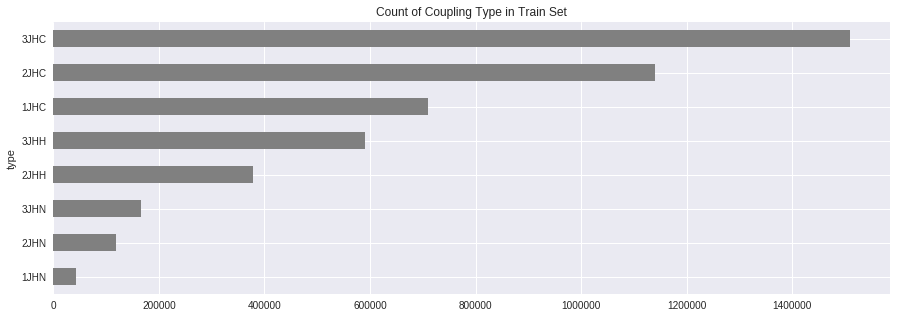

In [24]:
scaler.groupby('type').count()['molecule_name'].sort_values().plot(kind='barh',
                                                                color='grey',
                                                               figsize=(15, 5),
                                                               title='Count of Coupling Type in Train Set')
plt.show()

<pre><b>Evaluation Matrix</b>

Evaluation metric is important to understand as it determines how your model will be scored. Ideally we will set the loss function of our machine learning algorithm to use this metric so we can minimize the specific type of error.

Check out this kernel by @abhishek with code for the evaluation metric: https://www.kaggle.com/abhishek/competition-metric
</pre>

In [25]:
def Eval_matrix(data, preds):
    data["prediction"] = preds
    maes = []
    for t in data.type.unique():
        y_true = data[data.type==t].scalar_coupling_constant.values
        y_pred = data[data.type==t].prediction.values
        mae = np.log(metrics.mean_absolute_error(y_true, y_pred))
        maes.append(mae)
    return np.mean(maes)

<pre> Relationship between Target and Mulliken Features

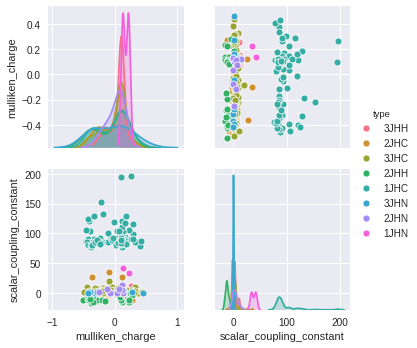

In [26]:
smul = mulliken.merge(train)
sns.pairplot(data=smul.sample(500), hue='type', vars=['mulliken_charge','scalar_coupling_constant'])
plt.show()

<pre>Relationship between Target and Magnetic Features</pre>

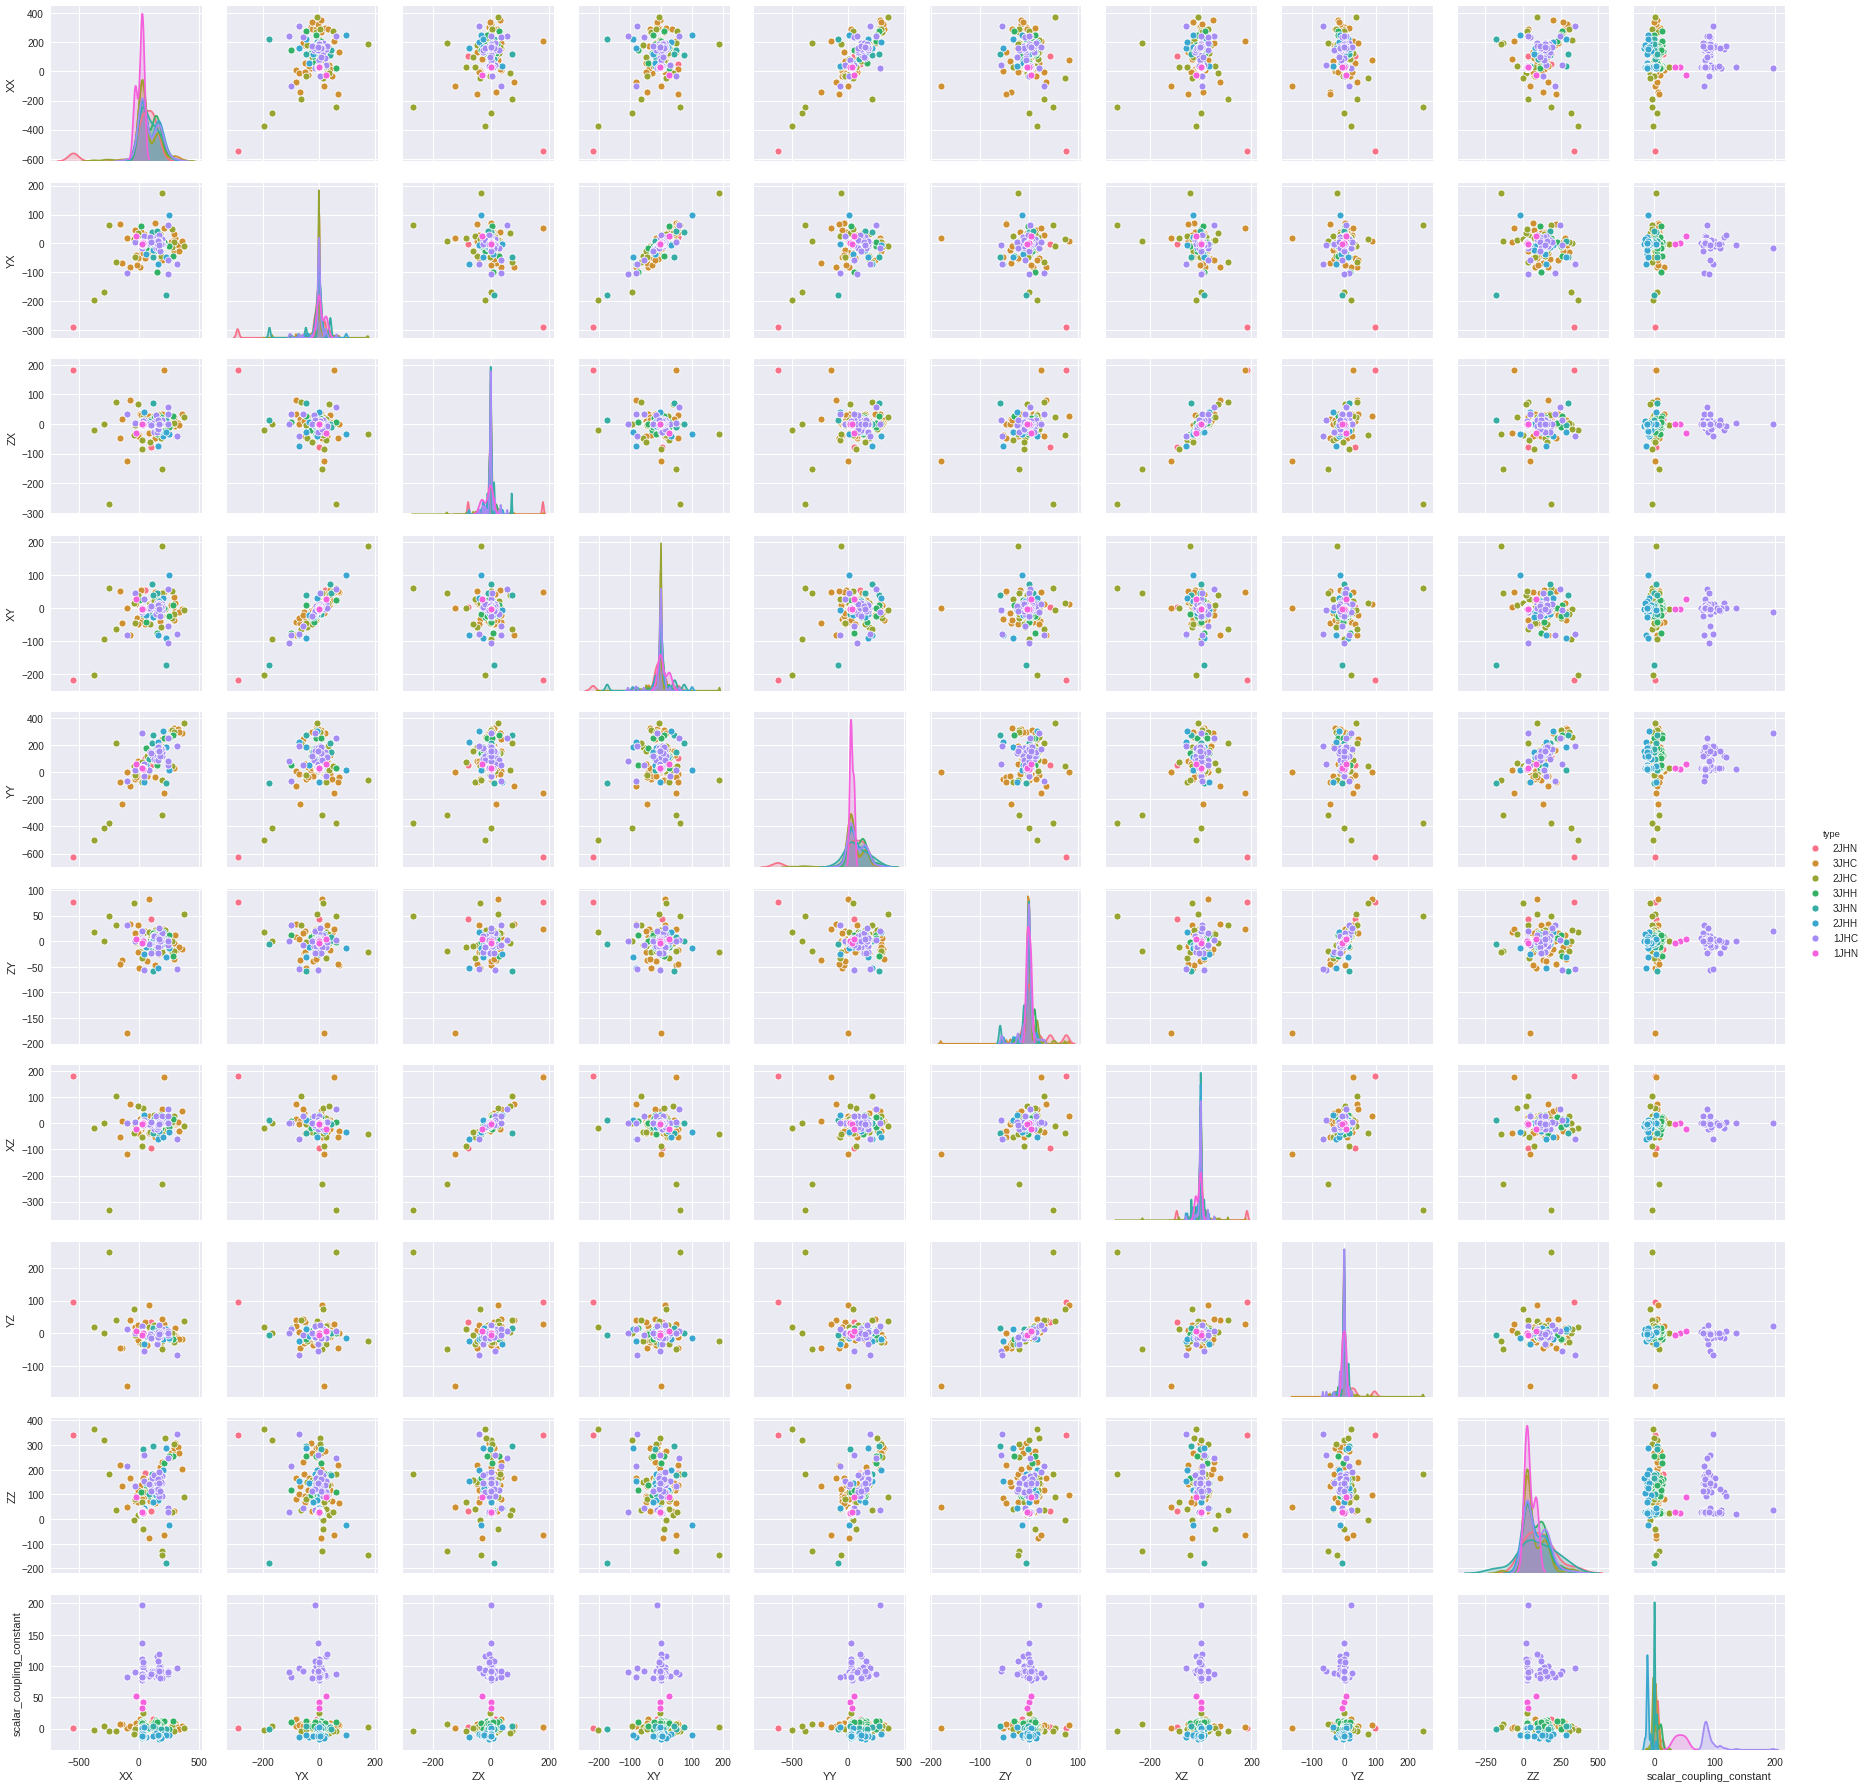

In [27]:
smg = magnetic.merge(train)
sns.pairplot(data=smg.sample(500), hue='type', vars=['XX','YX','ZX','XY','YY','ZY','XZ','YZ','ZZ','scalar_coupling_constant'])
plt.show()

<pre>Relationship between Target and Scalar Coupling Features</pre>

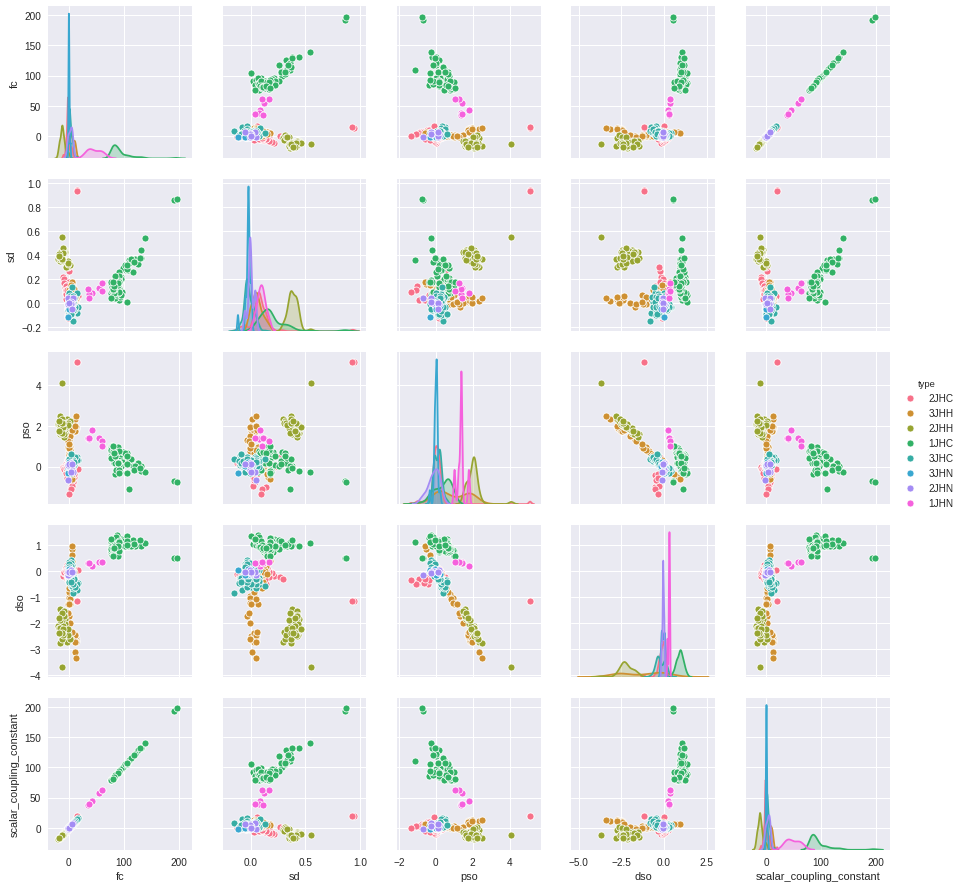

In [28]:
scc = scaler.merge(train)
sns.pairplot(data=scc.sample(500), hue='type', vars=['fc','sd','pso','dso','scalar_coupling_constant'])
plt.show()

In [29]:
gc.collect()

320407

<pre><b>Feature Creation<b>
This feature was found from @inversion 's kernel here: https://www.kaggle.com/inversion/atomic-distance-benchmark/output 
The code was then made faster by @seriousran here: https://www.kaggle.com/seriousran/just-speed-up-calculate-distance-from-benchmark</pre>

In [30]:
def map_atom_info(data, atom_idx):
    data = pd.merge(data, structure, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    data = data.drop('atom_index', axis=1)
    data = data.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return data

train = map_atom_info(train, 0)
train = map_atom_info(train, 1)

test = map_atom_info(test, 0)
test = map_atom_info(test, 1)

In [31]:
# https://www.kaggle.com/seriousran/just-speed-up-calculate-distance-from-benchmark
train_p_0 = train[['x_0', 'y_0', 'z_0']].values
train_p_1 = train[['x_1', 'y_1', 'z_1']].values
test_p_0 = test[['x_0', 'y_0', 'z_0']].values
test_p_1 = test[['x_1', 'y_1', 'z_1']].values

train['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)

In [32]:
# make categorical variables
atom_map = {'H': 0,
            'C': 1,
            'N': 2}
train['atom_0_cat'] = train['atom_0'].map(atom_map).astype('int')
train['atom_1_cat'] = train['atom_1'].map(atom_map).astype('int')
test['atom_0_cat'] = test['atom_0'].map(atom_map).astype('int')
test['atom_1_cat'] = test['atom_1'].map(atom_map).astype('int')

In [33]:
# One Hot Encode the Type
train_df = pd.concat([train, pd.get_dummies(train['type'])], axis=1)
test_df = pd.concat([test, pd.get_dummies(test['type'])], axis=1)

In [34]:
train['dist_to_type_mean'] = train['dist'] / train.groupby('type')['dist'].transform('mean')
test['dist_to_type_mean'] = test['dist'] / test.groupby('type')['dist'].transform('mean')

In [35]:
train.head(10)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dist,atom_0_cat,atom_1_cat,dist_to_type_mean
0,0,dsgdb9nsd_000001,1,0,1JHC,84.812500,H,0.002150,-0.006031,0.001976,C,-0.012695,1.085938,0.008003,1.091797,0,1,0.999023
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.257812,H,0.002150,-0.006031,0.001976,H,1.011719,1.463867,0.000277,1.783203,0,0,1.004883
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.257812,H,0.002150,-0.006031,0.001976,H,-0.541016,1.447266,-0.876465,1.782227,0,0,1.004883
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.257812,H,0.002150,-0.006031,0.001976,H,-0.523926,1.437500,0.906250,1.783203,0,0,1.004883
4,4,dsgdb9nsd_000001,2,0,1JHC,84.812500,H,1.011719,1.463867,0.000277,C,-0.012695,1.085938,0.008003,1.091797,0,1,0.999023
5,5,dsgdb9nsd_000001,2,3,2JHH,-11.257812,H,1.011719,1.463867,0.000277,H,-0.541016,1.447266,-0.876465,1.783203,0,0,1.004883
6,6,dsgdb9nsd_000001,2,4,2JHH,-11.257812,H,1.011719,1.463867,0.000277,H,-0.523926,1.437500,0.906250,1.782227,0,0,1.004883
7,7,dsgdb9nsd_000001,3,0,1JHC,84.812500,H,-0.541016,1.447266,-0.876465,C,-0.012695,1.085938,0.008003,1.091797,0,1,0.999023
8,8,dsgdb9nsd_000001,3,4,2JHH,-11.257812,H,-0.541016,1.447266,-0.876465,H,-0.523926,1.437500,0.906250,1.783203,0,0,1.004883
9,9,dsgdb9nsd_000001,4,0,1JHC,84.812500,H,-0.523926,1.437500,0.906250,C,-0.012695,1.085938,0.008003,1.091797,0,1,0.999023
